## 匯入套件
---

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import scipy.optimize as sco
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

import gym
import tensorflow.keras
import tensorflow as tf
import tensorflow_probability as tfp

from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## 產生股價資料
---

In [2]:
def stock_price_dataset(stock_name: str, start_day: str, end_day: str):
    data = web.DataReader(stock_name, data_source='yahoo',
                          start=start_day, end=end_day)
    
    # 刪除調整後收盤價
    data = data.iloc[:, :5]
    
    # 加入無風險利率&對數報酬率到表格中
    stock_return = [np.log(data['Close'][t]/data['Close'][t-1]) \
                    if t != 0 else 0 for t in range(len(data['Close']))]
    data.insert(0, 'RiskFree', 0.0207/252)
    data.insert(1, 'Return', stock_return)
    
    # 將對數報酬率欄位向上移動一格
    data['Return'] = data['Return'].shift(periods=-1, fill_value=0)
    
    # 加入無風險利率與對數報酬率之平均值
    data.insert(2, 'Average', (data['Return']+data['RiskFree'])/2)
    return data

In [3]:
# 選擇四檔股票作為標的: AAPL, KO, TSLA, BAC
start_day = '2012-04-10'
end_day   = '2022-05-01'

target_lst = ['AAPL', 'KO', 'TSLA', 'BAC']

AAPL = stock_price_dataset(target_lst[0], start_day, end_day)
KO   = stock_price_dataset(target_lst[1], start_day, end_day)
TSLA = stock_price_dataset(target_lst[2], start_day, end_day)
BAC  = stock_price_dataset(target_lst[3], start_day, end_day)

portfolio = pd.DataFrame({target_lst[0]: AAPL['Close'],
                          target_lst[1]: KO['Close'],
                          target_lst[2]: TSLA['Close'],
                          target_lst[3]: BAC['Close']})
print('portfolio data shape:', portfolio.shape)
portfolio.head()

portfolio data shape: (2533, 4)


,AAPL,KO,TSLA,BAC
Date,,,,
2012-04-09,22.722500,36.435001,2.210000,8.93
2012-04-10,22.444286,36.009998,2.164000,8.54
2012-04-11,22.364286,36.060001,2.206000,8.86
2012-04-12,22.241785,36.110001,2.229333,9.17
2012-04-13,21.615356,35.970001,2.239333,8.68


## 產生 Sharpe Ratio & 效率前緣線資訊
---

In [4]:
# 計算年化報酬&波動度
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [5]:
# 配置每個標的的隨機權重
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        # calculate the sharpe ratio
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [6]:
# 設置前兩個 function的參數
returns = portfolio.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0207/252

In [7]:
# 計算負的 Shapre ratio(因為scipy的optimizer是找其最小值)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    results = -(p_ret - risk_free_rate) / p_var
    return results

In [8]:
# 計算 Sharpe ratio的最大值
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    
    # 限制資產比例總和不超過1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    results = sco.minimize(negative_sharpe_ratio, num_assets * [1. / num_assets, ], 
                           args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return results

In [9]:
# 投資組合之波動度
def portfolio_volatility(weights, mean_returns, cov_matrix):
    results = portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]
    return results

In [10]:
# 計算投資組合中最小的波動度
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    results = sco.minimize(portfolio_volatility, num_assets * [1. / num_assets, ], 
                           args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return results

In [11]:
# 計算給定目標回報的最有效率的投資組合
def efficient_return(mean_returns, con_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    def portfolio_return(weights):
        results = portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]
        return results
    
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    results = sco.minimize(portfolio_volatility, num_assets * [1./num_assets],
                           args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return results

In [12]:
# 取得標的報酬率範圍且計算每個標的的有效投資組合
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [13]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate, display=False):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=portfolio.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=portfolio.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print('=' * 20)
    print('Maximum Sharpe Ratio Portfolio Allocation')
    print('Annualised Return:', round(rp, 2))
    print('Annualised Volatility:', round(sdp, 2))
    print('\n')
    print(max_sharpe_allocation)
    
    print('=' * 20)
    print('Minimum Volatility Portfolio Allocation')
    print('Annualised Return:', round(rp_min, 2))
    print('Annualised Volatility:', round(sdp_min, 2))
    print('\n')
    print(min_vol_allocation)
    
    print('=' * 20)
    print('Individual Stock Returns and Volatility')
    for i, txt in enumerate(portfolio.columns):
        print(txt, ':', 'annualised return', round(an_rt[i], 2), 
              ', annualised volatility', round(an_vol[i], 2))
    print('=' * 20)
    
    if display == True:
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.scatter(an_vol, an_rt, marker='o', s=200)
        
        for i, txt in enumerate(portfolio.columns):
            ax.annotate(txt, (an_vol[i], an_rt[i]), xytext=(10, 0), textcoords='offset points')
        ax.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe Ratio')
        ax.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Minimum Volatility')
        
        max_rt=0
        max_vol=0
        an_vol = np.std(returns) * np.sqrt(252)
        an_rt = mean_returns * 252
        
        # confirm the scales of x(volatility)
        for i, txt in enumerate(portfolio.columns):
            if max_rt > round(an_rt[i],2):
                max_rt = max_rt
            else:
                max_rt = round(an_rt[i],2)
            if max_vol > round(an_vol[i],2):
                max_vol = max_vol
            else:
                max_vol = round(an_vol[i],2)
        
        target = np.linspace(rp_min, max_rt+0.005, 50)
        efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
        ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
        ax.set_title('Portfolio Optimization with Individual Stocks')
        ax.set_xlabel('annualised volatility')
        ax.set_ylabel('annualised returns')
        ax.legend(labelspacing=0.8)
    else: pass
    return max_sharpe_allocation

Maximum Sharpe Ratio Portfolio Allocation
Annualised Return: 0.39
Annualised Volatility: 0.31


             AAPL   KO   TSLA    BAC
allocation  35.91  5.9  42.65  15.54
Minimum Volatility Portfolio Allocation
Annualised Return: 0.11
Annualised Volatility: 0.17


            AAPL     KO  TSLA   BAC
allocation  16.4  77.19  1.56  4.85
Individual Stock Returns and Volatility
AAPL : annualised return 0.23 , annualised volatility 0.29
KO : annualised return 0.07 , annualised volatility 0.18
TSLA : annualised return 0.64 , annualised volatility 0.56
BAC : annualised return 0.19 , annualised volatility 0.31


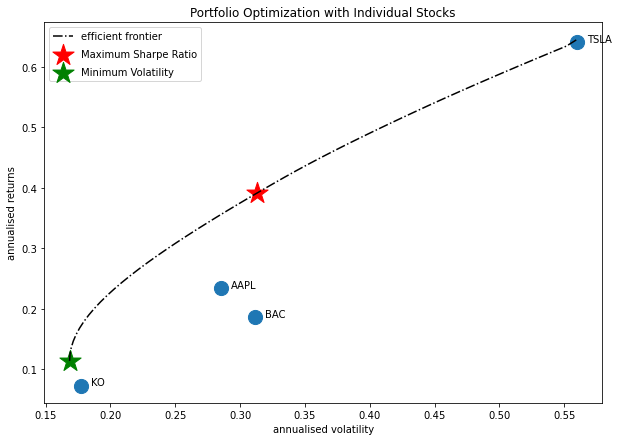

In [14]:
max_sharpe_allocation = display_ef_with_selected(
    mean_returns, cov_matrix, risk_free_rate, display=True
)
plt.savefig('efficient_frontier.png', dpi=100)

## Proximal Policy Optimization
---

#### 1. Memory
* 用以儲存每回合所需記憶的狀態參數

In [15]:
class PPOMemory:
    # 定義初始參數
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size
    
    # 產生批次中的資料
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int32)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        # print(self.states)
        return np.array(self.states),\
            np.array(self.actions),\
            np.array(self.probs),\
            np.array(self.vals),\
            np.array(self.rewards),\
            np.array(self.dones),\
            batches
    
    # 儲存參數
    def store_memory(self, state, action, probs,
                     vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
    
    # 清除參數
    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

#### 2. Network
* actor-critic algorithm

In [16]:
# 建立 actor model
class ActorNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=64, fc2_dims=32):
        super(ActorNetwork, self).__init__()

        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.fc3 = Dense(n_actions)

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)

        return x
    
    def reset(self, n_actions, fc1_dims=64, fc2_dims=32):
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.fc3 = Dense(n_actions)
        
# 建立 critic model
class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=64, fc2_dims=32):
        super(CriticNetwork, self).__init__()
        
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        q = self.q(x)

        return q
    
    def reset(self, fc1_dims=64, fc2_dims=32):
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

#### 3. Agent
* PPO agent

In [17]:
class Agent:
    # 定義初始參數
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003,
                 gae_lambda=0.95, policy_clip=0.2, batch_size=64,
                 n_epochs=10, chkpt_dir='models/'):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.chkpt_dir = chkpt_dir

        self.actor = ActorNetwork(n_actions)
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic = CriticNetwork()
        self.critic.compile(optimizer=Adam(learning_rate=alpha))
        self.memory = PPOMemory(batch_size)
    
    # 儲存狀態參數
    def store_transition(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)
    
    # 儲存模型
    def save_models(self):
        print('... saving models ...')
        self.actor.save(self.chkpt_dir + 'actor')
        self.critic.save(self.chkpt_dir + 'critic')
    
    # 讀取模型
    def load_models(self):
        print('... loading models ...')
        self.actor = keras.models.load_model(self.chkpt_dir + 'actor')
        self.critic = keras.models.load_model(self.chkpt_dir + 'critic')
    
    # 建立分佈並從中做出action
    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])

        probs = self.actor(state)
        dist = tfp.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic(state)

        action = action.numpy()[0]
        value = value.numpy()[0]
        log_prob = log_prob.numpy()[0]

        return action, log_prob, value
    
    # PPO 演算法
    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
                reward_arr, dones_arr, batches = \
                self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1] * (
                        1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t

            for batch in batches:
                with tf.GradientTape(persistent=True) as tape:
                    states = tf.convert_to_tensor(state_arr[batch])
                    old_probs = tf.convert_to_tensor(old_prob_arr[batch])
                    actions = tf.convert_to_tensor(action_arr[batch])

                    probs = self.actor(states)
                    dist = tfp.distributions.Categorical(probs)
                    new_probs = dist.log_prob(actions)

                    critic_value = self.critic(states)

                    critic_value = tf.squeeze(critic_value, 1)

                    prob_ratio = tf.math.exp(new_probs - old_probs)
                    weighted_probs = advantage[batch] * prob_ratio
                    clipped_probs = tf.clip_by_value(prob_ratio,
                                                     1-self.policy_clip,
                                                     1+self.policy_clip)
                    weighted_clipped_probs = clipped_probs * advantage[batch]
                    actor_loss = -tf.math.minimum(weighted_probs,
                                                  weighted_clipped_probs)
                    actor_loss = tf.math.reduce_mean(actor_loss)

                    returns = advantage[batch] + values[batch]
                    # critic_loss = tf.math.reduce_mean(tf.math.pow(
                    #                                  returns-critic_value, 2))
                    critic_loss = keras.losses.MSE(critic_value, returns)

                actor_params = self.actor.trainable_variables
                actor_grads = tape.gradient(actor_loss, actor_params)
                critic_params = self.critic.trainable_variables
                critic_grads = tape.gradient(critic_loss, critic_params)
                self.actor.optimizer.apply_gradients(
                        zip(actor_grads, actor_params))
                self.critic.optimizer.apply_gradients(
                        zip(critic_grads, critic_params))

        self.memory.clear_memory()
    
    def reset_agent(self, n_actions, alpha, batch_size):
        
        # 清空資料
        self.actor = ActorNetwork(n_actions)
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic = CriticNetwork()
        self.critic.compile(optimizer=Adam(learning_rate=alpha))
        self.memory = PPOMemory(batch_size)
        self.memory.clear_memory()
        
        # 清空model
        dir_path = 'C:\\Users\\ASUS\\Desktop\\Folder\\專題實作\\Ver_portfolioRL\\models'
        if os.path.isdir(dir_path): shutil.rmtree(dir_path, ignore_errors=True)

#### 4. Env
* 用以放入PPO模型之觀察空間

In [18]:
class envTrader(gym.Env):
    metadata = {"render.modes": ["human"]}
    
    # 定義初始參數
    def __init__(self, df, n_timestep, n_feature):
        super(envTrader, self).__init__()
        
        self.df = df
        self.idx = 0
        self.state = self.df.iloc[self.idx]
        
        self.n_action = 3  # hold, buy, average
        self.n_timestep = n_timestep
        self.n_feature = n_feature
        
        self.action_space = gym.spaces.Discrete(self.n_action)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.n_timestep, self.n_feature),
                                            dtype=np.float32)
    
    # 建立每回合中的動作狀況 & 設定rewards
    def step(self, actions):
        idx = self.idx
        df_idx = self.df.iloc[idx, :]
        reward = df_idx[actions] - ((df_idx['Average']+df_idx['Return'])/2)
        if reward > 0:
            reward = 1
        else:
            reward = 0
        return_ = df_idx[actions]
        idx = idx+1
        
        if idx >= len(self.df):
            done = True
            state = self.df.iloc[idx-1, :]
        
        else:
            done = False
            state = self.df.iloc[idx, :]
        
        self.state = state
        self.idx = idx
        
        return state, reward, done, actions, return_
    
    # 重新設置觀察空間
    def reset(self):
        self.idx = 0
        self.state = self.df.iloc[self.idx, :]
        
        return self.state
    
    # 視覺化訓練過程
    def render(self, mode="human"):
        pass
    
    # 關閉env
    def close(self):
        pass

## 產生訓練資料集
---

In [19]:
portfolio_AAPL = AAPL * (max_sharpe_allocation.at["allocation", "AAPL"]) * 0.01
portfolio_KO   = KO * (max_sharpe_allocation.at["allocation", "KO"]) * 0.01
portfolio_TSLA = TSLA * (max_sharpe_allocation.at["allocation", "TSLA"]) * 0.01
portfolio_BAC  = BAC * (max_sharpe_allocation.at["allocation", "BAC"]) * 0.01
portfolio = portfolio_AAPL + portfolio_KO + portfolio_TSLA + portfolio_BAC
portfolio = portfolio.drop("Volume", axis=1)
portfolio.head()

,RiskFree,Return,Average,High,Low,Open,Close
Date,,,,,,,
2012-04-09,0.000082,-0.021027,-0.010472,12.742488,12.478628,12.556830,12.639602
2012-04-10,0.000082,0.012715,0.006398,12.776645,12.384585,12.684715,12.434395
2012-04-11,0.000082,0.007941,0.004012,12.636882,12.378854,12.605486,12.476258
2012-04-12,0.000082,-0.017113,-0.008516,12.635431,12.397242,12.491966,12.493344
2012-04-13,0.000082,-0.030207,-0.015063,12.532380,12.145153,12.510760,12.188252


In [20]:
train_start = '2012-04-09'
train_end = '2021-05-10'

test_start = '2021-05-11'
test_end = '2022-05-10'

train = portfolio.loc[train_start:train_end]
test = portfolio.loc[test_start:test_end]

print('training size:', train.shape)
print('testing size:', test.shape)

training size: (2287, 7)
testing size: (246, 7)


## 訓練模型
---

In [21]:
# 設置env
env = envTrader(train, 5, train.shape[1])

# 設置超參數
batch_size = 1
n_epochs = 3  # identify
alpha = 0.0001

# 設置 PPO agent
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
              alpha=alpha, n_epochs=n_epochs,
              input_dims=env.observation_space.shape)

# 欲訓練次數
n_games = 100

# 儲存相關資訊: 最佳分數、rewards、returns、action
best_score = env.reward_range[0]
score_dict = {}
return_dict = {}
action_dict = {}


avg_score = 0
n_steps = 0
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    score_history = []
    return_history = []
    actions_history = []
    print('Game', i+1, end=': ')
    while not done:
        flag = 0
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, action, return_ = env.step(action)
        
        n_steps += 1
        score += reward
        agent.store_transition(observation, action,
                               prob, val, reward, done)
        if n_steps % batch_size == 0:
            agent.learn()
        observation = observation_
        return_history.append(return_)
        score_history.append(score)
        actions_history.append(action)
            
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
    score_dict['Epoch' + str(i+1)] = score_history
    return_dict['Epoch' + str(i+1)] = return_history
    action_dict['Epoch' + str(i+1)] = actions_history
    
    print('score %.7f' % score)

print('programs complete')

Game 1: ... saving models ...
INFO:tensorflow:Assets written to: models/actor\assets
INFO:tensorflow:Assets written to: models/critic\assets
score 1248.0000000
Game 2: ... saving models ...
INFO:tensorflow:Assets written to: models/actor\assets
INFO:tensorflow:Assets written to: models/critic\assets
score 1260.0000000
Game 3: score 1241.0000000
Game 4: score 1227.0000000
Game 5: score 1246.0000000
Game 6: ... saving models ...
INFO:tensorflow:Assets written to: models/actor\assets
INFO:tensorflow:Assets written to: models/critic\assets
score 1261.0000000
Game 7: score 1227.0000000
Game 8: score 1238.0000000
Game 9: score 1241.0000000
Game 10: score 1218.0000000
Game 11: score 1246.0000000
Game 12: score 1253.0000000
Game 13: ... saving models ...
INFO:tensorflow:Assets written to: models/actor\assets
INFO:tensorflow:Assets written to: models/critic\assets
score 1263.0000000
Game 14: score 1235.0000000
Game 15: score 1213.0000000
Game 16: score 1234.0000000
Game 17: score 1254.0000000
G

## 繪製訓練模型分數
---

In [41]:
pd.set_option('display.max_rows', None)

In [45]:
return_df = pd.DataFrame(return_dict)
return_df.to_csv('return.csv')
score_df = pd.DataFrame(score_dict)
score_df.to_csv('score.csv')
action_df = pd.DataFrame(action_dict)
action_df.to_csv('action.csv')

In [44]:
print(list(action_df.Epoch70).count(0))
print(list(action_df.Epoch70).count(1))
print(list(action_df.Epoch70).count(2))

74
2113
100


In [32]:
# 原始投資組合之累積報酬率
original_port_CumRate = []
original_return = 0
for i in train.iloc[:, 1]:
    original_return += i
    original_port_CumRate.append(original_return)
     
# 無風險利率(斜直線)
risk_free_CumRate = []
risk_free = 0
for i in range(train.shape[0]):
    risk_free = np.exp((i/250)*0.0207)-1
    risk_free_CumRate.append(risk_free)

# 平均無風險與投資報酬率下的累積報酬率
avg_port_CumRate = []
avg_return = 0
for i in train.iloc[:, 2]:
    avg_return += i
    avg_port_CumRate.append(avg_return)

# RL在actions下之累積報酬率
best_epoch = 'Epoch70'
RL_return = return_dict[best_epoch]
train_port_CumRate = []
train_return = 0
for i in RL_return:
    train_return += i
    train_port_CumRate.append(train_return)

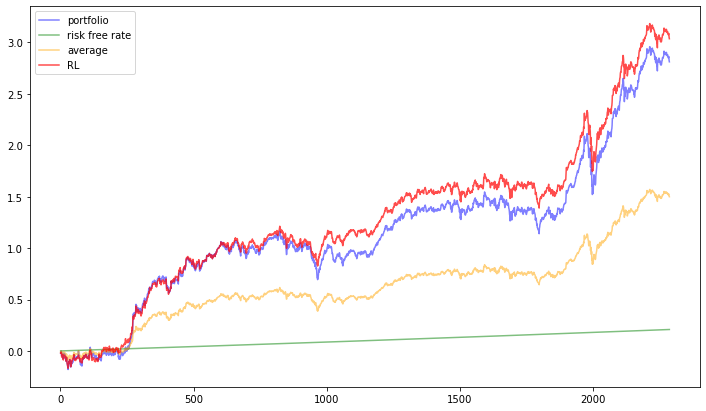

In [33]:
x = [i+1 for i in range(len(score_history))]
plt.figure(figsize=(12, 7))
plt.plot(x, original_port_CumRate, 'blue', alpha=0.5, label='portfolio')
plt.plot(x, risk_free_CumRate, 'g', alpha=0.5, label='risk free rate')
plt.plot(x, avg_port_CumRate, 'orange', alpha=0.5, label='average')
plt.plot(x, train_port_CumRate, 'red', alpha=0.7, label='RL')
plt.legend(loc='best')
plt.savefig('Result.png', dpi=200)
plt.show()

In [ ]:
# 設置env
env = envTrader(test, 5, test.shape[1])

# 設置超參數
batch_size = 1
n_epochs = 3  # identify
alpha = 0.0001

# 設置 PPO agent
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
              alpha=alpha, n_epochs=n_epochs,
              input_dims=env.observation_space.shape)

# 欲訓練次數
n_games = 100

# 儲存相關資訊: 最佳分數、rewards、returns、action
best_score = env.reward_range[0]
score_dict = {}
return_dict = {}
action_dict = {}


avg_score = 0
n_steps = 0
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    score_history = []
    return_history = []
    actions_history = []
    print('Game', i+1, end=': ')
    while not done:
        flag = 0
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, action, return_ = env.step(action)
        
        n_steps += 1
        score += reward
        agent.store_transition(observation, action,
                               prob, val, reward, done)
        if n_steps % batch_size == 0:
            agent.learn()
        observation = observation_
        return_history.append(return_)
        score_history.append(score)
        actions_history.append(action)
            
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
    score_dict['Epoch' + str(i+1)] = score_history
    return_dict['Epoch' + str(i+1)] = return_history
    action_dict['Epoch' + str(i+1)] = actions_history
    
    print('score %.7f' % score)

print('programs complete')

Game 1: ... saving models ...
INFO:tensorflow:Assets written to: models/actor\assets
INFO:tensorflow:Assets written to: models/critic\assets
score 131.0000000
programs complete


In [48]:
return_df = pd.DataFrame(return_dict)
return_df.to_csv('return_test.csv')
score_df = pd.DataFrame(score_dict)
score_df.to_csv('score_test.csv')
action_df = pd.DataFrame(action_dict)
action_df.to_csv('action_test.csv')

In [50]:
print(list(action_df.Epoch1).count(0))
print(list(action_df.Epoch1).count(1))
print(list(action_df.Epoch1).count(2))

0
246
0


In [51]:
# 原始投資組合之累積報酬率
original_port_CumRate = []
original_return = 0
for i in test.iloc[:, 1]:
    original_return += i
    original_port_CumRate.append(original_return)
     
# 無風險利率(斜直線)
risk_free_CumRate = []
risk_free = 0
for i in range(test.shape[0]):
    risk_free = np.exp((i/250)*0.0207)-1
    risk_free_CumRate.append(risk_free)

# 平均無風險與投資報酬率下的累積報酬率
avg_port_CumRate = []
avg_return = 0
for i in test.iloc[:, 2]:
    avg_return += i
    avg_port_CumRate.append(avg_return)

# RL在actions下之累積報酬率
best_epoch = 'Epoch1'
RL_return = return_dict[best_epoch]
train_port_CumRate = []
train_return = 0
for i in RL_return:
    train_return += i
    train_port_CumRate.append(train_return)

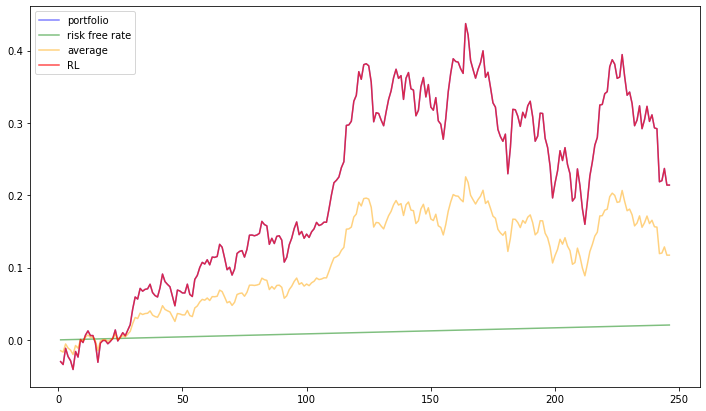

In [52]:
x = [i+1 for i in range(len(score_history))]
plt.figure(figsize=(12, 7))
plt.plot(x, original_port_CumRate, 'blue', alpha=0.5, label='portfolio')
plt.plot(x, risk_free_CumRate, 'g', alpha=0.5, label='risk free rate')
plt.plot(x, avg_port_CumRate, 'orange', alpha=0.5, label='average')
plt.plot(x, train_port_CumRate, 'red', alpha=0.7, label='RL')
plt.legend(loc='best')
plt.savefig('ResultTest.png', dpi=200)
plt.show()